# This notebook has 2 parts in it

1) Classification

2) Segmentation

**Based on the learnings and ideas from the interim model I tried few others as follows**



This notebook is continuation to interim notebook so.Some functions, datagenerators defined in that notebook are not defined again here

# **Classification**

*VGG16

*Model with cropped 

*NORMAL : 0, OTHERS :1

*Multi class classification

*Ensable with other dicom datas

# **VGG 16**

In [16]:
# importing vgg16
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

In [17]:
#creating datagenerator
datagen=ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,horizontal_flip=True,
                          width_shift_range=0.05,rescale=1/255,fill_mode='nearest',
                           preprocessing_function=preprocess_input,validation_split=0.1)

In [18]:
train=datagen.flow_from_directory('data',color_mode='rgb',batch_size=64,class_mode='binary',subset='training')
test=datagen.flow_from_directory('data',color_mode='rgb',batch_size=32,class_mode='binary',subset='validation')

Found 24016 images belonging to 2 classes.
Found 2668 images belonging to 2 classes.


In [19]:
train.class_indices

{'negative': 0, 'positive': 1}

In [20]:
# creating model
pre_trained_model = VGG16(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

58892288/58889256 [==============================] - 1s 0us/step
last layer output shape:  (None, 8, 8, 512)


In [21]:
# Top layers for classification
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LeakyReLU

model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.2)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

In [22]:
from tensorflow.keras.models import Model


vgg16model = Model( pre_trained_model.input, model) 

vgg16model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
vgg16model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [23]:
# call back function
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


early=EarlyStopping(monitor='accuracy',patience=2,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=0)

In [24]:
# class weight for balancing
class_weight={0:1,1:3.1}

In [25]:
history=vgg16model.fit(train,epochs=50,callbacks=[reduce_lr],steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Train for 100 steps, validate for 84 steps
Epoch 1/50
100/100 [==============================] - 181s 2s/step - loss: 1.0207 - accuracy: 0.7202 - val_loss: 1.2782 - val_accuracy: 0.8321
Epoch 2/50
100/100 [==============================] - 176s 2s/step - loss: 0.8396 - accuracy: 0.7439 - val_loss: 0.6965 - val_accuracy: 0.8298
Epoch 3/50
100/100 [==============================] - 176s 2s/step - loss: 0.7969 - accuracy: 0.7447 - val_loss: 0.6508 - val_accuracy: 0.8111
Epoch 4/50
100/100 [==============================] - 175s 2s/step - loss: 0.7687 - accuracy: 0.7550 - val_loss: 0.6498 - val_accuracy: 0.8313
Epoch 5/50
100/100 [==============================] - 174s 2s/step - loss: 0.7571 - accuracy: 0.7598 - val_loss: 0.6532 - val_accuracy: 0.7920
Epoch 6/50
100/100 [==============================] - 174s 2s/step - loss: 0.7295 - accuracy: 0.7616 - val_loss: 0.6489 - val_accuracy: 0.8032
Epoch 7/50
100/100 [==============================] - 175s 2s/step - loss: 0.7082 - accuracy: 0.772

**Evaluation**

In [26]:
vgg16model.save_weights('vggweights1650.h5')


In [27]:
kk=pd.DataFrame({'loss':history.history["loss"],'val_loss':history.history["val_loss"],
                 'accuracy':history.history["accuracy"],'val_acc':history.history["val_accuracy"]})

In [28]:
kk.to_csv('vgghistory1650.csv')

In [29]:
y=[]

test.reset()

for i in tqdm(range(84)):
    _,tar=test.__getitem__(i)
    for j in tar:
        y.append(j)

100%|██████████| 84/84 [00:44<00:00,  1.88it/s]


In [30]:
y_pred=vgg16model.predict(test)

In [31]:
pred_y=[]
for i in y_pred:
    if i>=0.03:
        pred_y.append(1)
    else:
        pred_y.append(0)

In [32]:
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report
print(classification_report(y,pred_y))

              precision    recall  f1-score   support

         0.0       0.98      0.27      0.43      2067
         1.0       0.28      0.99      0.44       601

    accuracy                           0.43      2668
   macro avg       0.63      0.63      0.43      2668
weighted avg       0.83      0.43      0.43      2668



In [33]:
from sklearn import metrics
print(metrics.roc_auc_score(y, y_pred))

0.866548817605233


It is less than VGG19

In [34]:
def evaluate_threshold(threshold):
    Sensitivity=tpr[thresholds > threshold][-1]
    Specificity= 1 - fpr[thresholds > threshold][-1]
    return Sensitivity,Specificity

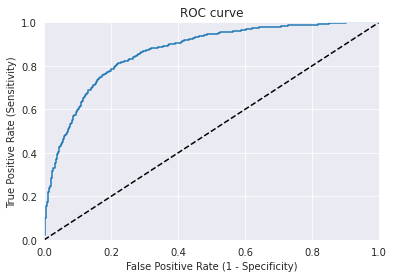

In [35]:
# ROC curve

import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr,fpr,linestyle='--',color='black')
plt.grid(True)

In [36]:
# threshold analysis
i=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
da=pd.DataFrame({})
for j in i:
    sen,spec=evaluate_threshold(j)
    da=da.append(pd.DataFrame({'Sensitivity':sen,'Specificity':spec},index=[j]))
display(da)    

,Sensitivity,Specificity
0.1,0.948419,0.498307
0.2,0.885191,0.658926
0.3,0.826955,0.747460
0.4,0.762063,0.816642
0.5,0.690516,0.860668
0.6,0.603993,0.897436
0.7,0.509151,0.928399
0.8,0.414309,0.956459
0.9,0.281198,0.979681


The area under the curve is 0.866 and the loss is 0.6948. This shows that the model VGG19 is showing a good performance

# Model on cropped images

In [3]:
hj=pd.read_csv('stage_2_train_labels.csv')


In [5]:
p=hj.drop_duplicates('patientId')


In [6]:
# by studying the distribution of the box centres we found that most of the boxes lies in this range
x1=int(150*128/1024)
x2=int(900*128/1024)
y1=int(200*128/1024)
y2=int(800*128/1024)
print(x1,y1,x2,y2)

18 25 112 100


In [7]:
# cropping and storing image
from tqdm import tqdm
dat=[]
i=0
for n, pid in tqdm(enumerate(p['patientId'])):
        if i<50000:
            dcm_file = 'stage_2_train_images/%s.dcm' % pid
            dcm_data = pydicom.read_file(dcm_file)
            dcm_data1=dcm_data.pixel_array
            img = cv2.resize(dcm_data1, dsize = (128,128))
            #hg=np.reshape(img,(128*128))
            dat.append(img[x1:x2,y1:y2])
            i=i+1
        else:
            break

26684it [11:27, 38.82it/s]


In [8]:
dat=np.array(dat)

In [9]:
dat.shape

(26684, 94, 75)

In [13]:
# loading target
y=p['Target']

In [14]:
# normalising
k=dat/255.0

In [ ]:
def create_network1(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Conv2D(128, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Conv2D(3, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1,activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=x)
    return model

In [16]:
# creating model
Cmodel2= create_network1(input_size=128, channels=32, n_blocks=2, depth=4)
Cmodel2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
# splitting data
from sklearn.model_selection import train_test_split
XX,xt,YY,yt=train_test_split(k,y,test_size=0.1,random_state=1)

In [18]:
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 50
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

class_weight={0:1,1:3}
history=Cmodel2.fit(XX,YY,verbose=1,epochs=50,callbacks=[learning_rate],validation_data=(xt, yt))


Epoch 1/50
751/751 [==============================] - 186s 248ms/step - loss: 0.4627 - accuracy: 0.7865 - val_loss: 0.4428 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 2/50
751/751 [==============================] - 186s 248ms/step - loss: 0.4437 - accuracy: 0.7946 - val_loss: 0.4442 - val_accuracy: 0.7924 - lr: 9.9901e-04
Epoch 3/50
751/751 [==============================] - 178s 237ms/step - loss: 0.4389 - accuracy: 0.7975 - val_loss: 0.4340 - val_accuracy: 0.7969 - lr: 9.9606e-04
Epoch 4/50
751/751 [==============================] - 180s 239ms/step - loss: 0.4346 - accuracy: 0.7975 - val_loss: 0.4429 - val_accuracy: 0.7951 - lr: 9.9114e-04
Epoch 5/50
751/751 [==============================] - 180s 239ms/step - loss: 0.4307 - accuracy: 0.8011 - val_loss: 0.5698 - val_accuracy: 0.6954 - lr: 9.8429e-04
Epoch 6/50
751/751 [==============================] - 180s 240ms/step - loss: 0.4281 - accuracy: 0.8014 - val_loss: 0.4429 - val_accuracy: 0.7984 - lr: 9.7553e-04
Epoch 7/50
751/751 [======

In [19]:
Cmodel2.save_weights('cropmodels50epochs.h5')

In [20]:
kk=pd.DataFrame({'loss':history.history["loss"],'val_loss':history.history["val_loss"],
                 'accuracy':history.history["accuracy"],'val_acc':history.history["val_accuracy"]})


In [21]:
kk.to_csv('historys50epochs.csv')

In [22]:
y_pred=Cmodel2.predict(xt)

In [23]:
# prediction
pred_y=[]
for i in y_pred:
    if i>=0.5:
        pred_y.append(1)
    else:
        pred_y.append(0)

In [24]:
# printing classificaiton score
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report
print(classification_report(yt,pred_y))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      2094
           1       0.60      0.42      0.50       575

    accuracy                           0.82      2669
   macro avg       0.73      0.67      0.69      2669
weighted avg       0.80      0.82      0.80      2669



In [25]:
# sensitivity study
def evaluate_threshold(threshold):
    Sensitivity=tpr[thresholds > threshold][-1]
    Specificity= 1 - fpr[thresholds > threshold][-1]
    return Sensitivity,Specificity

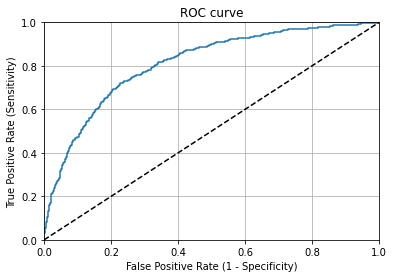

In [26]:
# ROC curve
from sklearn import metrics

import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(yt, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr,fpr,linestyle='--',color='black')
plt.grid(True)

In [27]:
i=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
da=pd.DataFrame({})
for j in i:
    sen,spec=evaluate_threshold(j)
    da=da.append(pd.DataFrame({'Sensitivity':sen,'Specificity':spec},index=[j]))
display(da)

,Sensitivity,Specificity
0.1,0.873043,0.572111
0.2,0.751304,0.730181
0.3,0.653913,0.816619
0.4,0.530435,0.875358
0.5,0.422609,0.924069
0.6,0.295652,0.952722
0.7,0.220870,0.974212
0.8,0.107826,0.988539
0.9,0.029565,0.998567


In [28]:
from sklearn import metrics
print(metrics.roc_auc_score(yt, y_pred))

0.8111432249491302


The area under the curve is 0.811 which is higher than when this model was trained on full image. thus croppig increase auc

# NORMAL : 0,  OTHERS :1 

**We doubted that the model with class lung opacity and no lung opacity / not normal might share more common features between theself than with the class normal thus we labelled these two class as 1 and normal as 0 and built a model**

In [12]:
y=p['class'].replace({'Normal':0,'Lung Opacity':1,'No Lung Opacity / Not Normal':1})

In [13]:
y.unique()

array([1, 0])

In [16]:
model3= create_network1(input_size=128, channels=32, n_blocks=2, depth=4)
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
from sklearn.model_selection import train_test_split
XX,xt,YY,yt=train_test_split(dat,y,test_size=0.1,random_state=1)

In [18]:
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 50
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

class_weight={0:1,1:3}
history=model3.fit(XX,YY,verbose=0,epochs=50,callbacks=[learning_rate],validation_data=(xt, yt))


In [19]:
model3.save_weights('Fmodel50epochs.h5')

In [20]:
kk=pd.DataFrame({'loss':history.history["loss"],'val_loss':history.history["val_loss"],
                 'accuracy':history.history["accuracy"],'val_acc':history.history["val_accuracy"]})


In [21]:
kk.to_csv('Fhistory50epochs.csv')

In [22]:
# predicting class for validation data
y_pred=model3.predict(xt)

In [23]:
pred_y=[]
for i in y_pred:
    if i>=0.5:
        pred_y.append(1)
    else:
        pred_y.append(0)

In [24]:
# classificaiton report
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report
print(classification_report(yt,pred_y))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       877
           1       0.87      0.86      0.86      1792

    accuracy                           0.82      2669
   macro avg       0.79      0.80      0.80      2669
weighted avg       0.82      0.82      0.82      2669



In [25]:
# area under the curve
from sklearn import metrics
print(metrics.roc_auc_score(yt, y_pred))

0.891741707729272


In [26]:
def evaluate_threshold(threshold):
    Sensitivity=tpr[thresholds > threshold][-1]
    Specificity= 1 - fpr[thresholds > threshold][-1]
    return Sensitivity,Specificity

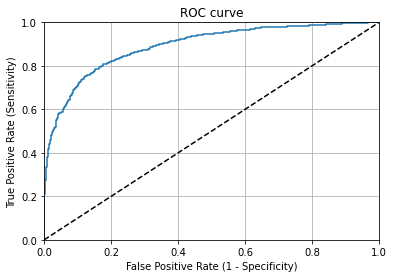

In [27]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities

import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(yt, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr,fpr,linestyle='--',color='black')
plt.grid(True)

In [28]:
i=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
da=pd.DataFrame({})
for j in i:
    sen,spec=evaluate_threshold(j)
    da=da.append(pd.DataFrame({'Sensitivity':sen,'Specificity':spec},index=[j]))
display(da)    

,Sensitivity,Specificity
0.1,0.983259,0.253136
0.2,0.956473,0.453820
0.3,0.929688,0.572406
0.4,0.900112,0.653364
0.5,0.855469,0.742303
0.6,0.819754,0.803877
0.7,0.766741,0.857469
0.8,0.686942,0.912201
0.9,0.569754,0.958951


The auc of this model high around 0.89. this confirm us that the dataset with class "lung opacity" and "no lung opacity/ Not normal" share more similarities with in themself than with class "Normal"

# **Multi class classification**

In [ ]:
hj=pd.read_csv('stage_2_train_class_info.csv')

In [ ]:
# Samples with class as Normal'
normal=hf[hf['class']=='Normal']
print(len(normal))


In [ ]:
# Samples with class as No Lung Opacity / Not Normal
nnormal=hf[hf['class']=='No Lung Opacity / Not Normal']
print(len(nnormal))


In [9]:
# Samples with class as lung opacity
positive=hf[hf['class']=='Lung Opacity']
unique_positive=positive[['path','patientId']]
path=unique_positive['path'].unique()
patientId=unique_positive['patientId'].unique()

In [10]:
# creating a dictionary for path and patientID
unique_positive=pd.DataFrame({'path':path,'patientId':patientId})

In [11]:
# Creating directories
os.mkdir('/data1')

os.mkdir('/data1/normal')

os.mkdir('/data1/no lungopacity and not normal') 

os.mkdir('/data1/lung opcaity')


In [13]:
# Reading dicom file and converting and storing the pixel pixel array data as jpg image with patientID as file name in lung opacity folder
for _,row in tqdm(unique_positive.iterrows()):
    img=dicom.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave('data1/lung opcaity/'+row['patientId']+'.jpg',img,cmap='gray')

6012it [06:07, 16.37it/s]


In [14]:
# Reading dicom file and converting and storing the pixel pixel array data as jpg image with patientID as file name in no lungopacity and not normal folder
for _,row in tqdm(nnormal.iterrows()):
    img=dicom.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave('data1/no lungopacity and not normal/'+row['patientId']+'.jpg',img,cmap='gray')

11821it [11:56, 16.50it/s]


In [15]:
# Reading dicom file and converting and storing the pixel pixel array data as jpg image with patientID as file name in normal folder
for _,row in tqdm(normal.iterrows()):
    img=dicom.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave('data1/normal/'+row['patientId']+'.jpg',img,cmap='gray')

8851it [09:12, 16.02it/s]


# **Training**

In [16]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [17]:
# creating mobilenet model and assigning layers as non trainable
def create_model(trainable=True):
    model = MobileNet(input_shape=(256, 256, 3), include_top=False, alpha=1, weights="imagenet")
    OO=0
    for layer in model.layers:
        layer.trainable = False
    return model        

In [18]:
Mmodel=create_model()

17227776/17225924 [==============================] - 0s 0us/step


In [19]:
# model summary
Mmodel.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32

In [20]:
# creating Datagenerator with Dataaggumentation and standardisation
datagen=ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,horizontal_flip=True,
                          width_shift_range=0.05,rescale=1/255,fill_mode='nearest',
                           preprocessing_function=preprocess_input,validation_split=0.1)

In [21]:
# creating training and validation set with 0.9:0.1 ratio
train=datagen.flow_from_directory('data',color_mode='rgb',batch_size=64,class_mode='categorical',subset='training')
test=datagen.flow_from_directory('data',color_mode='rgb',batch_size=32,class_mode='categorical',subset='validation')

Found 24016 images belonging to 3 classes.
Found 2668 images belonging to 3 classes.


In [22]:
train.class_indices

{'lung opcaity': 0, 'no lungopacity and not normal': 1, 'normal': 2}

In [23]:

# loading last layer of mobilenet model (without top)

last_layer =Mmodel.get_layer('conv_pw_13_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 8, 8, 1024)


In [24]:
# adding further layers to mobilenet model to do classificaiton
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LeakyReLU

model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.2)(model)
model=BatchNormalization()(model)
model = Dense(3, activation='softmax')(model)

In [25]:
# creating and compiling model
from tensorflow.keras.models import Model


f3model = Model( Mmodel.input, model) 

f3model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
f3model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)      128   

In [26]:
# setting callback with earlystop and reducing learing rate
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


early=EarlyStopping(monitor='accuracy',patience=3,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=0)

In [27]:
# creating class weight as data is not balanced
class_weight={0:2.5,1:1,2:1}
              

In [28]:
# training
history=f3model.fit(train,epochs=50,callbacks=[reduce_lr],steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Epoch 1/50
100/100 [==============================] - 382s 4s/step - loss: 1.8483 - accuracy: 0.5483 - val_loss: 0.9350 - val_accuracy: 0.6376 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 395s 4s/step - loss: 1.0843 - accuracy: 0.6119 - val_loss: 0.7672 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 403s 4s/step - loss: 1.0269 - accuracy: 0.6320 - val_loss: 0.7717 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 381s 4s/step - loss: 0.9800 - accuracy: 0.6325 - val_loss: 0.7260 - val_accuracy: 0.6732 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 393s 4s/step - loss: 0.9413 - accuracy: 0.6598 - val_loss: 0.7552 - val_accuracy: 0.6642 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 395s 4s/step - loss: 0.8993 - accuracy: 0.6697 - val_loss: 0.7450 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - 378s 4s/st

In [29]:
# saving weights for future use
fmodel.save_weights('3classmobilenet150.h5')


In [31]:
kk=pd.DataFrame({'loss':history.history["loss"],'val_loss':history.history["val_loss"],
                 'accuracy':history.history["accuracy"],'val_acc':history.history["val_accuracy"]})

In [32]:
# saving the history
kk.to_csv('3Mmodel150.csv')

In [33]:
# the report shows that this model is better than model 1, let check the sensitivity and specificity

In [34]:
y=[]

test.reset()

for i in tqdm(range(84)):
    _,tar=test.__getitem__(i)
    for j in tar:
        y.append(j)

100%|██████████| 84/84 [00:48<00:00,  1.72it/s]


In [35]:
y_pred=fmodel.predict(test)

In [36]:
y_pred.shape

(2668, 3)

In [37]:
np.argmax(y_pred[1])

1

In [38]:
np.array(y).shape

(2668, 3)

In [39]:
# target labels
YY=[]
for i in y:
    YY.append(np.argmax(i))

In [40]:
# predictions
pred_y=[]
for i in y_pred:
    pred_y.append(np.argmax(i))

In [41]:
# classification report
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report
print(classification_report(YY,pred_y))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       601
           1       0.65      0.55      0.60      1182
           2       0.69      0.82      0.75       885

    accuracy                           0.64      2668
   macro avg       0.63      0.65      0.64      2668
weighted avg       0.64      0.64      0.64      2668



In [ ]:
The accuracy of this model is 64 percent

# Ensamble model with dicom data like age, sex, View position

In [121]:
# custom generator class for classification
class generator1(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32,channel=1, image_size=128, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.channel=channel
        self.on_epoch_end()
        
    def __load__(self, filename):
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        msk = np.zeros(1)
        images=np.zeros((self.image_size,self.image_size,self.channel))
        filename = filename.split('.')[0]
        if filename in pneumonia_locations:
            msk[0]=1
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        for i in range(self.channel):
            images[:,:,i]=img
        #img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return images, msk
    
    def __loadpredict__(self, filename):
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        images=np.zeros((self.image_size,self.image_size,self.channel))
        for i in range(self.channel):
            images[:,:,i]=img
        #img = np.expand_dims(img, -1)
        return images
        
    def __getitem__(self, index):
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.predict:
            images = [self.__loadpredict__(filename) for filename in filenames]
            images = np.array(images)
            return images, filenames
        else:
            items = [self.__load__(filename) for filename in filenames]
            imgs, msks = zip(*items)
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            return int(len(self.filenames) / self.batch_size)   


In [122]:
# creating separate generators for custom and vgg, mobilnet as they use different input shapes

train_gens = generator1(folder, train_filenames, pneumonia_locations, batch_size=1,channel=1, image_size=128, shuffle=False, augment=False, predict=False)
valid_gens= generator1(folder, valid_filenames, pneumonia_locations, batch_size=1,channel=1, image_size=128, shuffle=False, predict=False)

train_genmv = generator1(folder, train_filenames, pneumonia_locations, batch_size=1,channel=3, image_size=256, shuffle=False, augment=False, predict=False)
valid_genmv= generator1(folder, valid_filenames, pneumonia_locations, batch_size=1,channel=3, image_size=256, shuffle=False, predict=False)



In [28]:
# creating model
Smodel= create_network1(input_size=128, channels=32, n_blocks=2, depth=4)

In [29]:
# loading trained weights
Smodel.load_weights('model50epochs.h5')

In [30]:
# creating mobile net and loading trained weights
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

from tensorflow.keras.models import Model
def create_model(trainable=True):
    model = MobileNet(input_shape=(256, 256, 3), include_top=False, alpha=1, weights="imagenet")
    OO=0
    for layer in model.layers:
        layer.trainable = False
    return model       
Mmodel=create_model()
last_layer =Mmodel.get_layer('conv_pw_13_relu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LeakyReLU

model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.2)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)



mfmodel = Model( Mmodel.input, model) 

mfmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


last layer output shape:  (None, 8, 8, 1024)


In [31]:
# Loading pretrained model
mfmodel.load_weights('mobilenet20.h5')

In [17]:
# creating model and Loading pretrained model
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input

pre_trained_model = VGG19(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# creating further layers to add to vgg19 for classification 
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Model

model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.2)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

Vmodel = Model( pre_trained_model.input, model) 

Vmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
Vmodel.summary()
Vmodel.load_weights('vggweights14.h5')

80142336/80134624 [==============================] - 2s 0us/step
last layer output shape:  (None, 8, 8, 512)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
________________

In [42]:
# predicting the class
Sp=Smodel.predict(valid_gens)
Mp=fmodel.predict(valid_genmv)
Vp=Vmodel.predict(valid_genmv)

In [ ]:
valid_genmv1= generator1(folder, valid_filenames, pneumonia_locations, batch_size=1,channel=3, image_size=256, shuffle=False, predict=True)

In [35]:
# loading target
from tqdm import tqdm

vy=[]


for i in tqdm(range(2668)):
    _,tar=valid_gens.__getitem__(i)
    for j in tar:
        vy.append(j)

100%|██████████| 2668/2668 [02:45<00:00, 16.11it/s]


In [36]:
#loading target
sy=[]


for i in tqdm(range(2668)):
    _,tar=valid_genmv.__getitem__(i)
    for j in tar:
        sy.append(j)
        

100%|██████████| 2668/2668 [02:44<00:00, 16.19it/s]


In [39]:
(np.array(vy)-np.array(sy)).sum()

0.0

In [83]:
# creating a custom report function
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report
from sklearn import metrics

def report(y,y_pred,th):
    vpred_y=[]
    for i in y_pred:
        if i>=th:
            vpred_y.append(1)
        else:
            vpred_y.append(0)
    print(classification_report(y,vpred_y))      
    print(metrics.roc_auc_score(y,y_pred))

In [124]:
# generating report 
report(YY1,Sp,0.2)
report(YY1,Mp,0.32)
report(YY1,Vp,0.1)

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2035
           1       0.59      0.72      0.65       633

    accuracy                           0.82      2668
   macro avg       0.75      0.78      0.76      2668
weighted avg       0.83      0.82      0.82      2668

0.8637236978469206
              precision    recall  f1-score   support

           0       0.92      0.85      0.89      2035
           1       0.62      0.77      0.69       633

    accuracy                           0.83      2668
   macro avg       0.77      0.81      0.79      2668
weighted avg       0.85      0.83      0.84      2668

0.8930679925940589
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2035
           1       0.24      1.00      0.38       633

    accuracy                           0.24      2668
   macro avg       0.12      0.50      0.19      2668
weighted avg       0.06      0.24   

Mobilenet with this generator function gives better AUC than any other model till now and since the prediction of VGG is low in auc and accuracy with this custom function we will use only the outputs of mobile net and custom architecture for ensambling

In [161]:
#Creating custom data from predictions for ensambling
TSp=Smodel.predict(train_gens)
TMp=fmodel.predict(train_genmv)


In [106]:
dc=pd.read_csv('/kaggle/input/dicomdata/saved.csv')
dc=dc.drop_duplicates('patientId')
dc.shape

(26684, 14)

In [107]:
dc.columns

Index(['Unnamed: 0', 'Modality', 'PatientAge', 'ViewPosition', 'PatientSex',
       'PatientOrientation', 'BodyPartExamined', 'patientId', 'x', 'y',
       'width', 'height', 'Target', 'class'],
      dtype='object')

In [125]:
dd=dc[['PatientAge','PatientSex','patientId','Target','ViewPosition']]

In [127]:
# appending Patient ID and predicitons
vaF=[]
trF=[]
for i in valid_filenames:
    k=i.split('.')[0]
    vaF.append(k)
for i in train_filenames:
    k=i.split('.')[0]
    trF.append(k)
    
dd['valid']=dd['patientId'].isin(vaF)
dd['train']=dd['patientId'].isin(trF)
ddt=dd[dd['train']]
ddv=dd[dd['valid']]

tt=pd.DataFrame({})
tt['patientId']=trF
tt['rank']=np.arange(0,24016)
tt['mobile']=TMp
tt['self']=TSp
tv=pd.DataFrame({})
tv['patientId']=vaF
tv['rank']=np.arange(0,2668)
tv['mobile']=Mp
tv['self']=Sp

In [156]:
tv.head()

,patientId,rank,mobile,self
0,10f82565-f6b0-4dd0-a570-1f324161c8e9,0,0.251111,0.267861
1,8fd19393-b0d1-45eb-aba4-11519def129a,1,0.035524,0.031615
2,336b379f-b679-42cb-9e9b-e2483a4cae2c,2,0.008033,0.006167
3,6c93d95a-2f16-46ea-88d8-84906aa27d64,3,0.049973,0.121540
4,9f586862-a0d0-4980-ac2e-7a82c9d4c30b,4,0.765934,0.653634


In [176]:
# training set
Traind=pd.merge(tt,ddt)
Traind.head()
TrainData=Traind[['mobile','self','PatientAge','PatientSex','ViewPosition']]
TrainData1=pd.get_dummies(TrainData,columns=['PatientSex','ViewPosition'])

TrainData1.to_csv('T.csv')

In [177]:
# validayion set
Validd=pd.merge(tv,ddv)
ValidData=Validd[['mobile','self','PatientAge','PatientSex','ViewPosition']]
ValidData1=pd.get_dummies(ValidData,columns=['PatientSex','ViewPosition'])

ValidData1.to_csv('v.csv')

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from catboost import CatBoostClassifier
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [170]:
#Creating a Function to append the  scores of the algorithms
def trialscore(names, models, x, y,xv,yv):
    Model = []
    accuracy = []
    recall = []
    auc=[]
    for name, model in zip(names, models):
        Model.append(name)
        model.fit(x,y)
        Yv=model.predict(xv)
        auc.append(metrics.roc_auc_score(yv,Yv))
        accuracy.append(metrics.accuracy_score(yv,Yv))
        recall.append(metrics.recall_score(yv,Yv))
        
        
    consolidate=pd.DataFrame({'Model': Model,
                              'AUC': auc,
                              'Accuracy':accuracy,
                              'recall': recall})
    return consolidate

In [174]:
# different models to be tried
names = ['Logistic Regression','Gaussian Classifier','support vector Classifier', 'Decision Tree Classifier', 
         'Random Forest Classifier', 'Gradient Boosting Classfier',
         'Adaboost Classifier','Bagging Classifier','XGboost']
models = [LogisticRegression(),GaussianNB(),
          SVC(), DecisionTreeClassifier(random_state=1),
          RandomForestClassifier(random_state=1), GradientBoostingClassifier(random_state=1), 
          AdaBoostClassifier(random_state=1),BaggingClassifier(random_state=1),xgb.XGBClassifier(random_state=1,objective='binary:logistic')]


In [175]:
training and results
consolidate=trialscore(names, models, TrainData1,Traind['Target'],ValidData1,Validd['Target'])
display(consolidate)

,Model,AUC,Accuracy,recall
0,Logistic Regression,0.749627,0.853823,0.551343
1,Gaussian Classifier,0.784599,0.832459,0.693523
2,support vector Classifier,0.504739,0.764993,0.009479
3,Decision Tree Classifier,0.706173,0.790855,0.545024
4,Random Forest Classifier,0.734568,0.835832,0.541864
5,Gradient Boosting Classfier,0.746766,0.851949,0.546603
6,Adaboost Classifier,0.746853,0.854573,0.541864
7,Bagging Classifier,0.712785,0.828336,0.492891
8,XGboost,0.739868,0.845577,0.538705


**Observation**

From this we can see that the mobilenet model with custom generator is the best so far. with auc of 0.89

Ensamble did not work

but cropping the image had a positive effect on results

Normal:0 and others 1 also works very vell

VGG 19 is better than VGG 16 for this task, but VGG16 trained faster than VGG19

Model like mobile net is the fastet so far in training, then the VGG16 then VGG19

self created architecture is as fast as mobile net due to the fact that data is stored in array for that


#  Segmentation model

As already state we can run the exsting model for more epochs

In [ ]:
# model function
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=128, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# creating model
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(128, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2DTranspose(64, (8,8), (4,4), padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**(depth-2))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    #print(y_true)
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
   
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# set batch size and image size
BATCH_SIZE = 16
IMAGE_SIZE = 128

In [1]:
 #As this model takes more time to run 3 epochs were run at a time, weights were saved, reloaded again, learing rate 
# is adjusted and this process is repeated till curves got stabilized
# Create model and compile model
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4) 
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

MULTI_PROCESSING = True 


def cosine_annealing(x):
    lr = 0.001
    epochs = 39
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

#loading pretrained weights at interim model for 11 epochs

model.load_weights('segmentmodel.h5')

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], use_multiprocessing=True, epochs=39, shuffle=True, verbose=0)
model.save_weights('segmentmodel50.h5')

In [ ]:
kk=pd.DataFrame({'loss':history.history["loss"],'val_loss':history.history["val_loss"],
                 'accuracy':history.history["accuracy"],'val_acc':history.history["val_accuracy"],
                 'mean_iou':history.history["mean_iou"],'val_mean_iou':history.history["val_mean_iou"]})
#Saving history for later use
kk.to_csv('segmenthistory50.csv')

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# the entire history (0 to 50 epochs) in manually combined in excel separately as seg.csv.
kk=pd.read_csv('seg.csv')

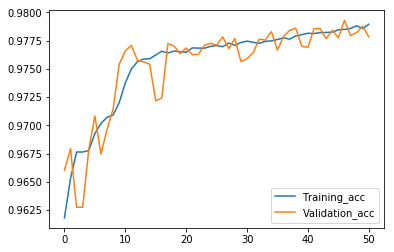

In [7]:
# plotting the accuracy
plt.plot(kk.index,kk.Training_acc, label="Training_acc")
plt.plot(kk.index,kk.val_acc,label="Validation_acc")
plt.legend(loc="lower right")

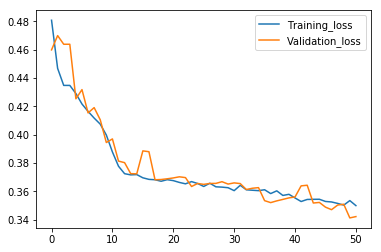

In [9]:
# plotting the accuracy
plt.plot(kk.index,kk.loss, label="Training_loss")
plt.plot(kk.index,kk.val_loss,label="Validation_loss")
plt.legend(loc="upper right")

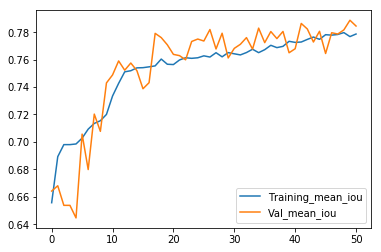

In [11]:
plt.plot(kk.index,kk.mean_iou, label="Training_mean_iou")
plt.plot(kk.index,kk.val_mean_iou,label="Val_mean_iou")
plt.legend(loc="lower right")

The curves have stabilized better than before with validation accuracy of  0.9778, Loss 0.342, Mean_IOU:0.7844
    
Model performance has increased with Epochs

**Predicting Sample Images**

In [12]:
# non max suppression
def non_max_suppression_slow(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
  
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

  
        for pos in range(0, last):
     
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

      
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            overlap = float(w * h) / area[j]
            if overlap > overlapThresh:
                suppress.append(pos)
        idxs = np.delete(idxs, suppress)

    return boxes[pick]

In [30]:
# mask predict function
def predict(batch,num):
    k=0
    f, ax = plt.subplots(1,3, figsize=(16,18))
    X=np.array(valid_gen[batch][0][num])
    Y=np.array(valid_gen[batch][1][num])
    ypred=model.predict(X.reshape(1,128,128,1))
    ximg=np.reshape(X,(128,128))
    ximgp=ximg.copy()
    Y=np.reshape(Y,(128,128))
    yp=np.reshape(ypred,(128,128))
    k=0
        
    THRESHOLD=0.3
    region=np.reshape(ypred,(128,128))
    output = np.zeros((128,128), dtype=np.uint8)
    for i in range(region.shape[1]):
        for j in range(region.shape[0]):
            if region[i][j] > THRESHOLD:
                x = int(j)
                y = int(i)
                x2 = int((j + 1))
                y2 = int((i + 1))
            #cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)
                output[y:y2,x:x2] = 1
                #print(x,y,x2,y2)

    contours,_ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    bb=[]
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt,0.00000001* cv2.arcLength(cnt, True), True)
        x, y, w, h = cv2.boundingRect(approx)
        bb.append((x,y,x+w,y+h))
    box=non_max_suppression_slow(np.array(bb),0.5)
    for po in box:
        cv2.rectangle(region, (po[0], po[1]), (po[2], po[3]), (255, 255, 255), 1)
        print('box dim x,y,w,h:', po[0], po[1],po[2]-po[0], po[3]-po[1])
        
    
    
    j=['XRAY','MASK','Prediction']
    for i in [ximg,Y,region]:
        if k==0:
            ax[k].imshow(i, cmap=plt.cm.gist_gray)
        else:
            ax[k].imshow(i)
        ax[k].set_title(j[k])
        k=k+1
    plt.show()
    cv2.waitKey(0)
    cv2.destroyAllWindows()
        

box dim x,y,w,h: 68 28 40 80
box dim x,y,w,h: 20 24 36 80


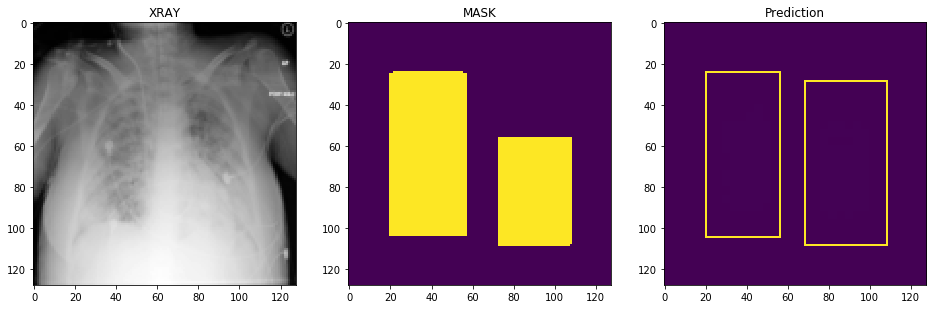

In [31]:
 predict(0,14)

box dim x,y,w,h: 28 24 32 64


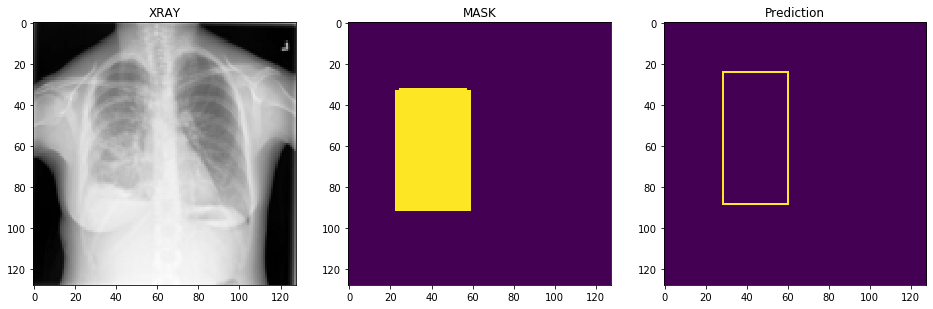

In [33]:
 predict(20,14)

box dim x,y,w,h: 80 40 32 52
box dim x,y,w,h: 36 40 28 44


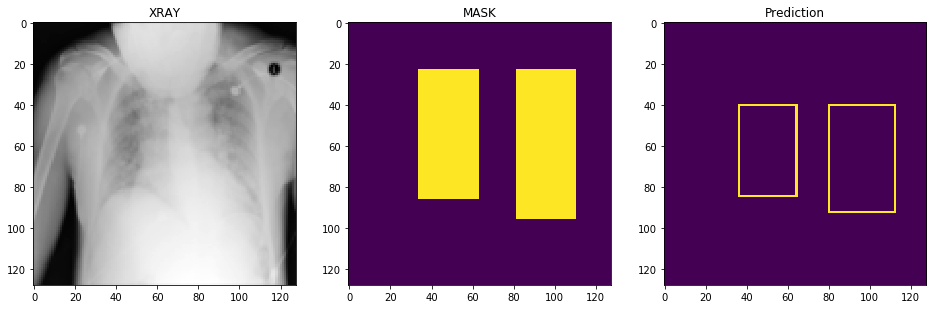

In [35]:
 predict(10,5)

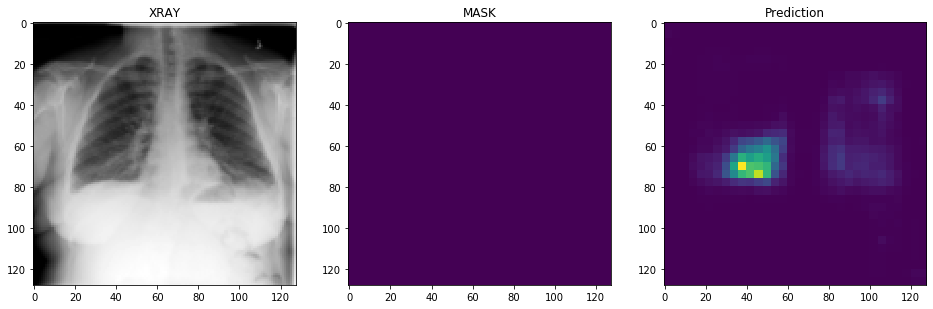

In [16]:
 predict(20,1)

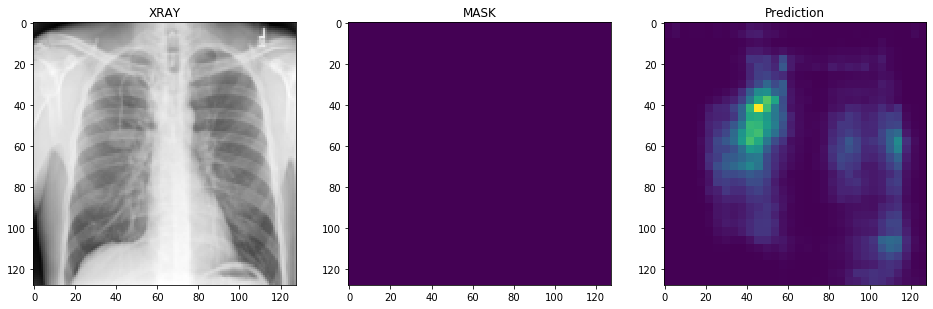

In [17]:
 predict(20,3)

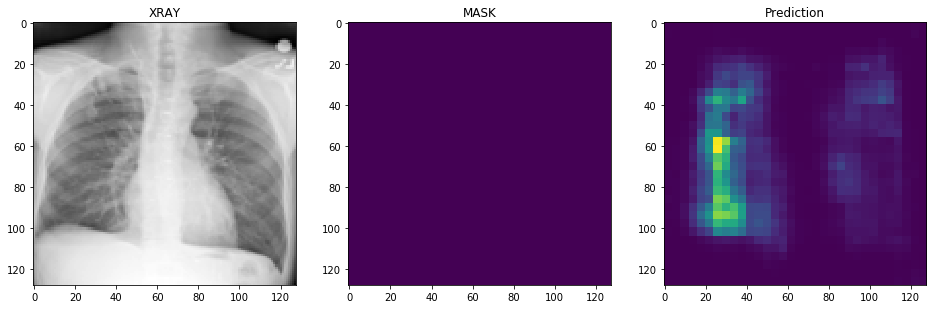

In [38]:
 predict(30,14)

box dim x,y,w,h: 16 28 40 76
box dim x,y,w,h: 64 28 44 76


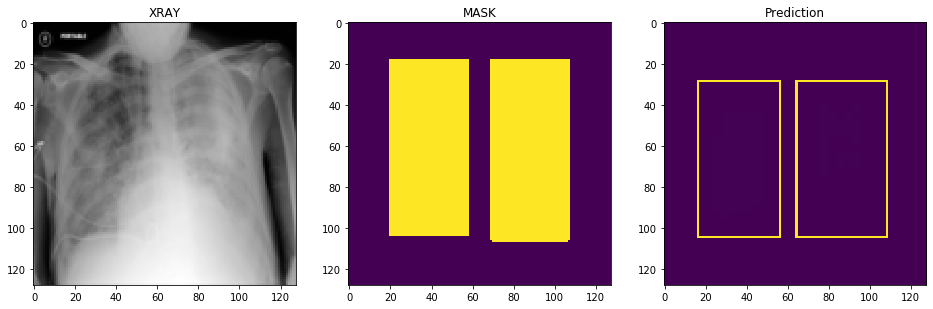

In [39]:
 predict(36,14)

box dim x,y,w,h: 72 32 36 80
box dim x,y,w,h: 20 28 40 76


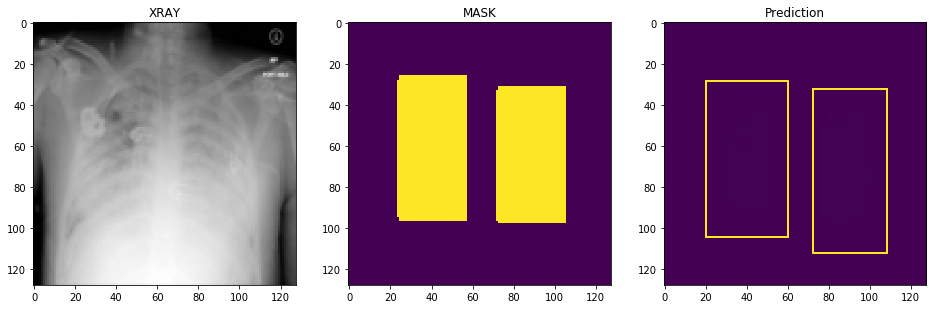

In [40]:
 predict(36,7)

box dim x,y,w,h: 24 32 36 52
box dim x,y,w,h: 72 36 36 48


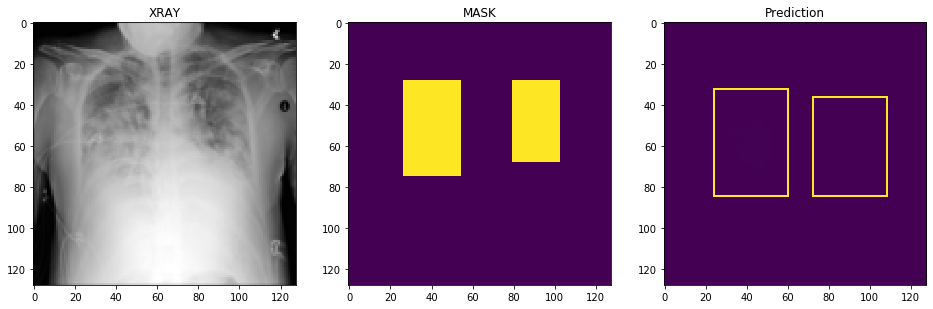

In [41]:
 predict(36,13)

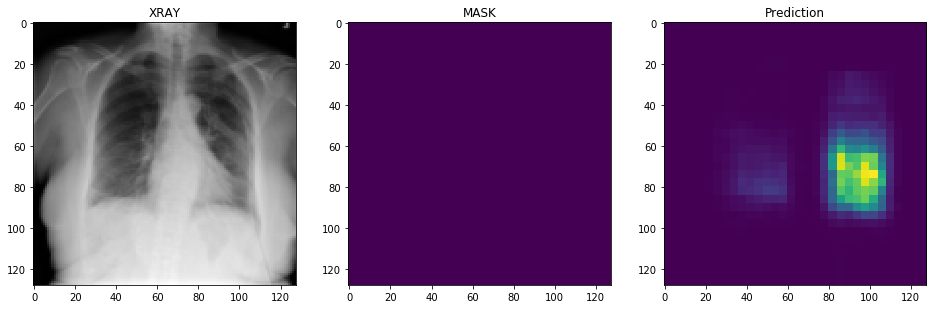

In [44]:
 predict(42,3)

The model is correctly creating bounding boxes on the locations as in mask.if the image has no lung opacity the model is not creating bounding box. even if there are some yellow patches in the prediction, their values are less than threshold. so no bounding boxes